# はじめに
メンバーシップ推定攻撃の対策手法がどの程度効果があるか評価します。  

### 概要
- メンバーシップ推定攻撃の対策手法であるMemGuardの効果を検証します。  
- メンバーシップ推定攻撃としては、機械学習モデルを用いる手法を用います。  


# MemGuard

### 基本的な考え方
モデルの出力にノイズを加えることで、メンバーシップ推定攻撃をしにくくする防御手法です。  
ノイズは、メンバーシップ推定攻撃の成功確率を最小化するように生成しますが、下記条件を満たす必要があります。  
1. ノイズによって予測ラベルが変更されない
2. ノイズの大きさの期待値が事前に決められた閾値以下
3. ノイズを加えた後の出力が、確率の条件を満たす（各要素が正かつ総和が1）

### 実装上の工夫
上記の条件を満たすノイズを効率的に作成するために、2段階の手法として、MemGuardは実装されています。  
一段階目のPhase Iでは、ノイズの大きさに関する条件（条件2）を考慮せずにノイズを作成し、Phase IIで条件を満たすようにノイズを加えるかの判断を行います。

### Phase I
元の最適化問題との違いは下記の点になります。  

- softmax後の出力ではなく、その前のlogitにノイズを加える。  
そうすることで、出力が確率の条件を満たすか（条件3）を考慮しなくて済みます。  
- ノイズの大きさを最小化する問題に置き換える。  
その代わりに、防御の強さに関する条件として、ノイズ付加後のメンバーシップ推定攻撃のinとoutの予測確率を等しくなるようにする。  

整理すると、下記3つの損失の重みづけ和を最小化します。  
L1：メンバーシップ推定攻撃の攻撃モデルのlogitのL1ノルム（防御の強さの条件）  
L2：元の予測クラスのlogitをその他のクラスのlogitが超える場合は、それらの差（条件1）  
L3：ノイズの大きさ  

全体の損失を、L=L1+c2×L2+c3×L3 として、最小となるノイズを求めます。  
ここで、c2、c3は事前に設定したパラメータです。  
また、条件を満たすノイズが見つからない場合は、ノイズは 0 とします。

### Phase II
Phase Iで求めたノイズは、大きさの条件を考慮していないため、ノイズの大きさの期待値が閾値以下になるように調整します。  

まず、ノイズを加えた時に、メンバーシップ推定攻撃の成功率を下げられない場合は、ノイズを付加しません。  
それ以外の場合は、閾値をε、ノイズの大きさをdとすると、確率 min(ε/d,1) でノイズを付加します。  
この結果、付加するノイズの大きさの期待値をε以下にすることができます。  

### パラメータc3の探索
Phase Iのパラメータc3は、ノイズの大きさと防御の強さを調整するパラメータです。  
大きすぎると十分な防御にならず、小さすぎるとノイズが大きくなりすぎます。  
効果的に防御するためには、適切にc3を決定する必要があります。

そこで、サンプルごとにc3を最適化します。  
まず、小さい値を用いてノイズを作成し、2つの条件を満たすか確認します。  
- ノイズによって予測ラベルが変更されない
- 十分強い防御になっている（ノイズの有無でメンバーシップ推定攻撃の予測が変わる）  

条件を満たす場合は、c3を10倍して、再度ノイズの最適化を行います。  
これを繰り返すことで、条件を満たすノイズのうち、c3が最大（つまり、ノイズが最も小さい）ものを採用します。  




# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import os
import pickle

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  


In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
!nvidia-smi

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch: 2.2.1+cu121
Torchvision: 0.17.1+cu121
Wed Mar 20 06:18:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |         

### 3. データセットの用意  

カラー画像データセットのCIFAR-10を、torchvisionを用いて取得します。  
全てのデータに、下記の操作を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


In [3]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)



100%|██████████| 170498071/170498071 [00:06<00:00, 24747179.00it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. 学習

今回は、異なる条件で複数回学習を実行するため、学習部分を関数として定義します。
教師データの分割では、再現可能なようにシードを固定しています。
学習したモデルは今後再利用可能なように、保存しておきます。  


In [4]:
def training(batch_size = 128, idx=0, dir='/content/drive/MyDrive/MemGuard'):
    if os.path.exists(f"{dir}/model_{idx}.pt"):
        print(f"model_{idx}.pt exist")
        return

    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    train_dataloader = DataLoader(train_in, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18(num_classes=10)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # training
    pbar = tqdm(range(30), desc=f"[idx: {idx}]")
    for epoch in pbar:

        model.train()
        for (X, y) in train_dataloader:
            X, y = X.to(device), y.to(device)

            # optimization step
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'{idx} test accuracy: {test_acc}')

    #save model
    torch.save(model.state_dict(), f"{dir}/model_{idx}.pt")

# victim model
training(idx=0)
# shadow model
training(idx=100)

model_0.pt exist
model_100.pt exist


### 5. メンバーシップ推定攻撃
防御およびメンバーシップ推定攻撃のために、memberかnon-memberかを判定する攻撃モデルの学習を行います。  
被害モデルは防御のために、shadow modelはメンバーシップ推定攻撃のために使用します。


In [5]:
def make_attack_dataset(target_idx=0, n_models=1, dir='/content/drive/MyDrive/MemGuard'):
    if os.path.exists(f'{dir}/attack_dataset_{target_idx}.pkl'):
        print(f"attack_dataset_{target_idx}.pkl exist")
        return

    pred_list = []
    ans_list = []
    class_list = []
    for idx in range(target_idx, target_idx+n_models):
        #split training data
        train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

        # make dataloader
        in_loader = DataLoader(train_in, batch_size=1024, shuffle=False)
        out_loader = DataLoader(train_out, batch_size=1024, shuffle=False)

        # make model
        model = torchvision.models.resnet18(num_classes=10)

        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        fname = f"{dir}/model_{idx}.pt"
        model.load_state_dict(torch.load(fname))
        print(f'{fname} loaded')
        model.eval()

        # MIA
        # member
        with torch.no_grad():
            for X, y in in_loader:
                X, y = X.to(device), y.to(device)

                pred =  torch.nn.Softmax()(model(X))
                pred_list.append(pred.to('cpu').numpy())
                ans_list.append(np.ones(pred.shape[0]))
                class_list.append(y.to('cpu').numpy())
        #non-member
        with torch.no_grad():
            for X, y in out_loader:
                X, y = X.to(device), y.to(device)

                pred =  torch.nn.Softmax()(model(X))
                pred_list.append(pred.to('cpu').numpy())
                ans_list.append(np.zeros(pred.shape[0]))
                class_list.append(y.to('cpu').numpy())

    pred = np.concatenate(pred_list)
    ans = np.concatenate(ans_list)
    c = np.concatenate(class_list)
    print(pred.shape, ans.shape, c.shape)

    f = open(dir + f'/attack_dataset_{target_idx}.pkl', 'wb')
    pickle.dump((pred, ans, c), f)

make_attack_dataset(target_idx=0)
make_attack_dataset(target_idx=100)

attack_dataset_0.pkl exist
attack_dataset_100.pkl exist


#### 攻撃モデルの学習
3層のニューラルネットワークを用いて攻撃モデルの学習を行います。

In [6]:
class FC(nn.Module):
    def __init__(self, num_class=2, input_size=10, num_layer=3, num_unit=100):
        super().__init__()
        self.num_layer=num_layer
        self.l1 = nn.Linear(in_features=input_size,out_features=num_unit)
        self.l2 = nn.Linear(in_features=num_unit, out_features=num_unit)
        self.l3 = nn.Linear(in_features=num_unit, out_features=num_class)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

def train_attack_model(target_idx=0, dir='/content/drive/MyDrive/MemGuard'):


    f = open(dir + f'/attack_dataset_{target_idx}.pkl', 'rb')
    (pred, ans, c) = pickle.load(f)

    for class_idx in range(10):
        if os.path.exists(f'{dir}/attack_{target_idx}_{class_idx}.pt'):
            print(f"attack_{target_idx}_{class_idx}.pt exist")
            continue

        x = pred[c==class_idx]
        y = ans[c==class_idx]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.int64)
        train_dataset = torch.utils.data.TensorDataset(x, y)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=128,
            shuffle=True
        )

        model = FC()
        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        model.train()

        criterion = torch.nn.CrossEntropyLoss()
        # training attack dataset
        pbar = tqdm(range(30), desc=f"[class idx: {class_idx}]")
        for epoch in pbar:
            losses = []
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                pbar.set_postfix(loss=np.mean(losses))

        torch.save(model.state_dict(), f"{dir}/attack_{target_idx}_{class_idx}.pt")


train_attack_model(target_idx=0)
train_attack_model(target_idx=100)

attack_0_0.pt exist
attack_0_1.pt exist
attack_0_2.pt exist
attack_0_3.pt exist
attack_0_4.pt exist
attack_0_5.pt exist
attack_0_6.pt exist
attack_0_7.pt exist
attack_0_8.pt exist
attack_0_9.pt exist
attack_100_0.pt exist
attack_100_1.pt exist
attack_100_2.pt exist
attack_100_3.pt exist
attack_100_4.pt exist
attack_100_5.pt exist
attack_100_6.pt exist
attack_100_7.pt exist
attack_100_8.pt exist
attack_100_9.pt exist


### 6. MemGuard
MemGuardのphase1に従って、ノイズを作成します。  
この際に、被害モデルと被害モデルを使って作成した攻撃モデルを用います。

In [7]:
def MemGuard_phase1(dataset, target_idx=0, dir='/content/drive/MyDrive/MemGuard'):

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

    # load target modeol
    target_model = torchvision.models.resnet18(num_classes=10)
    target_model = target_model.to(device)
    target_model.load_state_dict(torch.load(f"{dir}/model_{target_idx}.pt"))
    target_model.eval()

    # load attack models
    attack_models = []
    for class_idx in range(10):
        attack_model = FC()
        attack_model = attack_model.to(device)
        attack_model.load_state_dict(torch.load(f"{dir}/attack_{target_idx}_{class_idx}.pt"))
        attack_model.eval()
        attack_models.append(attack_model)

    success_count = 0
    protected_output = []
    original_output = []
    class_label = []
    # for i in tqdm(range(len(dataset))):
    for i in tqdm(range(500)):
        x, y = dataset[i]
        attack_model = attack_models[y]
        class_label.append(y)

        x = torch.stack([x])
        x = x.to(device)

        logit_org = target_model(x).detach().clone()

        pred_org = np.argmax(logit_org[0].to('cpu').detach().numpy())
        last_output = nn.Softmax()(logit_org)[0].to('cpu').detach().clone()
        original_output.append(last_output)

        mia_logit = attack_model(nn.Softmax()(logit_org))
        mia_pred_org = nn.Softmax()(mia_logit).to('cpu').detach()[0,0]

        if np.abs(mia_pred_org - 0.5) <= 1e-5:
            protected_output.append(last_output)
            success_count += 1
            continue

        mask = F.one_hot(torch.tensor([y]),10)
        mask = mask.to(device)

        c1=1.0
        c2=10.0
        c3=0.1
        max_iter=300
        iterate_time = 1
        while True:
            logit = logit_org.detach().clone()
            logit.requires_grad = True

            pred = np.argmax(logit[0].to('cpu').detach().numpy())
            mia_logit = attack_model(nn.Softmax()(logit))
            mia_pred = nn.Softmax()(mia_logit).to('cpu').detach()[0,0]

            j = 1
            while j < max_iter and (pred != pred_org or (mia_pred - 0.5)*(mia_pred_org - 0.5) > 0):

                loss1 = torch.sum(torch.abs(mia_logit), dim=1)

                correct_logit = torch.sum(logit*mask, dim=1)
                wrong_logit = torch.amax(logit*(1-mask) - 1e8*mask, dim=1)
                loss2 = F.relu(wrong_logit - correct_logit)

                loss3 = torch.sum(torch.abs(nn.Softmax()(logit) - nn.Softmax()(logit_org)), dim=1)

                loss = loss1 + c2*loss2 + c3*loss3
                loss = loss.mean()
                attack_model.zero_grad()
                loss.backward()

                grad = logit.grad.data
                grad = grad / torch.norm(grad)
                logit = logit - 0.1*grad

                logit = logit.detach()
                logit.requires_grad = True

                pred = np.argmax(logit[0].to('cpu').detach().numpy())
                mia_logit = attack_model(nn.Softmax()(logit))
                mia_pred = nn.Softmax()(mia_logit).to('cpu').detach()[0,0]
                # print(j,mia_pred, loss1, loss2, loss3)
                j += 1

            if pred != pred_org:
                break
            if (mia_pred - 0.5)*(mia_pred_org - 0.5) > 0:
                success_count += 1
                break
            last_output = nn.Softmax()(logit)[0].to('cpu').detach().clone()
            iterate_time += 1
            c3 *= 10

            if c3 > 100000:
                success_count += 1
                break
        protected_output.append(last_output)
        # print(i, 'iteration', iterate_time, 'original: mia', mia_pred_org, 'prediction', pred_org, 'protected: mia', mia_pred, 'prediction', pred)
        # break
    print(success_count, len(dataset))
    return protected_output, original_output, class_label


dir='/content/drive/MyDrive/MemGuard'
idx = 0
if os.path.exists(f'{dir}//memguard_phase1_{idx}.pkl'):
    print(f"memguard_phase1_{idx}.pkl exist")
else:
    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    out = []
    protected_in, original_in, class_in = MemGuard_phase1(train_in, target_idx=idx)
    out.append((protected_in, original_in, class_in))
    protected_out, original_out, class_out = MemGuard_phase1(train_out, target_idx=idx)
    out.append((protected_out, original_out, class_out))

    f = open(dir + f'/memguard_phase1_{idx}.pkl', 'wb')
    pickle.dump(out, f)


memguard_phase1_0.pkl exist


MemGuardのphase2では、ノイズの大きさの期待値が閾値以下になるように、確率的にノイズを付加します。

epsilon: 1.0, MIA accuracy: 0.618, AUC: 0.666
epsilon: 0.5, MIA accuracy: 0.619, AUC: 0.668
epsilon: 0.3, MIA accuracy: 0.62, AUC: 0.669
epsilon: 0.1, MIA accuracy: 0.644, AUC: 0.690
epsilon: 0.0, MIA accuracy: 0.663, AUC: 0.694


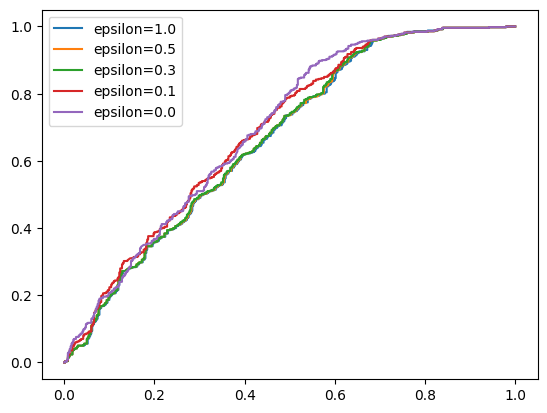

In [8]:
def MemGuard_phase2(protected, original, class_label, epsilon, target_idx=0, dir='/content/drive/MyDrive/MemGuard'):

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

    # load attack models
    attack_models = []
    for class_idx in range(10):
        attack_model = FC()
        attack_model = attack_model.to(device)
        attack_model.load_state_dict(torch.load(f"{dir}/attack_{target_idx}_{class_idx}.pt", map_location=device))
        attack_model.eval()
        attack_models.append(attack_model)

    output = []
    for i in range(len(protected)):

        attack_model = attack_models[class_label[i]]

        output_org = original[i]
        output_org = torch.stack([output_org])
        output_org = output_org.to(device)

        output_protected = protected[i]
        output_protected = torch.stack([output_protected])
        output_protected = output_protected.to(device)

        mia_pred_org = nn.Softmax(dim=1)(attack_model(output_org)).to('cpu').detach()[0,1]
        mia_pred_protected = nn.Softmax(dim=1)(attack_model(output_protected)).to('cpu').detach()[0,1]

        if np.abs(mia_pred_org-0.5)<=np.abs(mia_pred_protected-0.5):
            output.append(original[i])
        else:
            diff = np.sum(np.abs((output_org - output_protected).to('cpu').detach().numpy()))
            p = min(epsilon / diff, 1.0)
            if np.random.random() <= p:
                output.append(protected[i])
            else:
                output.append(original[i])

    return output

def run_MIA(output, class_label, attack_idx=100):
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    output = torch.stack(output)
    class_label = np.array(class_label)

    mia_pred = []
    for class_idx in range(10):
        attack_model = FC()
        attack_model = attack_model.to(device)
        attack_model.load_state_dict(torch.load(f"{dir}/attack_{attack_idx}_{class_idx}.pt", map_location=device))
        attack_model.eval()

        tmp_output = output[class_label==class_idx]
        tmp_output = tmp_output.to(device)
        mia_pred.append(nn.Softmax(dim=1)(attack_model(tmp_output)).to('cpu').detach().numpy()[:,1])

    mia_pred = np.concatenate(mia_pred)
    return mia_pred

idx = 0
dir='/content/drive/MyDrive/MemGuard'
f = open(dir + f'/memguard_phase1_{idx}.pkl', 'rb')
out = pickle.load(f)

protected_in, original_in, class_in = out[0]
protected_out, original_out, class_out = out[1]


for epsilon in [1.0, 0.5, 0.3, 0.1, 0.0]:
    output_in = MemGuard_phase2(protected_in, original_in, class_in, epsilon, idx)
    mia_pred_in = run_MIA(output_in, class_in, attack_idx=100)
    ans_in = np.ones(mia_pred_in.shape)

    output_out = MemGuard_phase2(protected_out, original_out, class_out, epsilon, idx)
    mia_pred_out = run_MIA(output_out, class_out, attack_idx=100)
    ans_out = np.zeros(mia_pred_out.shape)

    ans = np.concatenate([ans_in, ans_out])
    mia_pred = np.concatenate([mia_pred_in, mia_pred_out])

    fpr, tpr, thresholds = metrics.roc_curve(ans, mia_pred)
    mia_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f'epsilon={epsilon}')

    mia_pred = np.rint(mia_pred)
    mia_accuracy = metrics.accuracy_score(ans, mia_pred)

    print(f'epsilon: {epsilon}, MIA accuracy: {mia_accuracy}, AUC: {mia_auc:0.3f}')
plt.legend()
plt.show()


# おわりに


### 今回の結果
MemGuardを用いることで、ノイズが大きいほどメンバーシップ推定攻撃の成功率を下げることができていることを確認できました。  
ただし、予測クラスに影響を与えないという条件があるため、防御としての限界はあるように思えました。  

### 次にやること
他の防御手法も検証してみたいと思います。

### 参考資料
- J. Jia et al., MemGuard: Defending against Black-Box Membership Inference Attacks via Adversarial Examples, CCS, 2019
- MemGuard  
https://github.com/jinyuan-jia/MemGuard
- R. Shokri et al., Membership Inference Attacks Against Machine Learning Models, IEEE S&P, 2017  
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
- CIFAR-10  
https://www.cs.toronto.edu/~kriz/cifar.html  

